<a href="https://colab.research.google.com/github/sarychief/nlp-tasks/blob/main/AI_tranform_ds_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)





In [46]:
import re
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import contractions
from bs4 import BeautifulSoup
import tqdm
import unicodedata
import nltk

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder

In [18]:
# чтение файла
data = pd.read_csv("/content/data.csv.gz", encoding="utf8")

Информация о данных: количество строк, столбцов, имен столбцов, ненулевых значений и типов данных

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


Статистика о числовых столбцах, таких как счетчик, среднее значение, мин, макс и квартили

In [20]:
data.describe()

,rating
count,92735.000000
mean,4.064086
std,1.620702
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


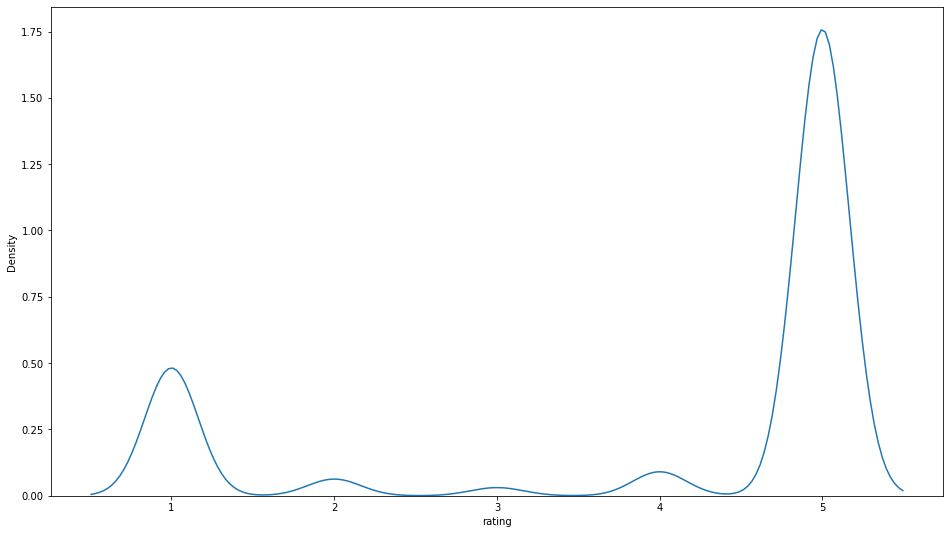

In [63]:
plt.figure(figsize=(16,9))
sns.kdeplot(data.rating)

Можно сделать вывод, что люди в целом склонны ставить либо  самую максимальную (что чаще всего), либо самую минимальную. 


Выведем первые 5 полей датафрейма

In [21]:
data.head()

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


Список всех банков с сайта

In [22]:
data.bank_name.unique()

array(['Еком Банк', 'Тинькофф Банк', 'Банк Открытие', 'Газпромбанк',
       'Точка', 'ВТБ', 'Почта Банк', 'Хоум Кредит Банк', 'ОТП Банк',
       'Банк «Санкт-Петербург»', 'Совкомбанк', 'Альфа-Банк', 'Ак Барс',
       'Модульбанк', 'ЮниКредит Банк', 'Россельхозбанк', 'СберБанк',
       'МТС Банк', 'Озон Банк', 'Александровский', 'Ситибанк',
       'КИВИ Банк', 'Росбанк', 'Кредит Европа Банк', 'Транскапиталбанк',
       'Ренессанс Кредит', 'Райффайзен Банк', 'ЮMoney', 'ББР Банк',
       'Московский Кредитный Банк',
       'Всероссийский Банк Развития Регионов', 'Авангард',
       'Азиатско-Тихоокеанский Банк', 'Драйв Клик Банк', 'Промсвязьбанк',
       'Уральский Банк Реконструкции и Развития', 'Русский Стандарт',
       'Руснарбанк', 'Юнистрим', 'Абсолют Банк', 'Банк ДОМ.РФ',
       'БКС Банк', 'Банк Зенит', 'Банк Уралсиб', 'Кубань Кредит',
       'Локо-Банк', 'Татсоцбанк', 'Финам Банк', 'Норвик Банк',
       'Банк Синара (СКБ-банк)', 'Экспобанк', 'Хлынов', 'Икано Банк',
       'Банк Ак

---
### Топ-15 банков по рейтингу

In [58]:
(data
 .groupby('bank_name', as_index=False)
 .agg({"rating": 'mean'})
 .sort_values(["rating"], ascending=[False])
 .head(15)
)

,bank_name,rating
0,TalkBank,5.000000
134,Татсоцбанк,5.000000
79,Мир Бизнес Банк,5.000000
65,Костромаселькомбанк,5.000000
62,Калуга,5.000000
60,Ишбанк,5.000000
89,Муниципальный Камчатпрофитбанк,5.000000
46,Гарант-Инвест,5.000000
106,Промтрансбанк,5.000000
35,Белгородсоцбанк,5.000000


Можно заметить, что максимальные оценки ставят малоизвестным банкам. Скорее всего это связано с малым количеством клиентов. Из предыдущенго графика можно предположить, что если клиента сервис устраивает, то он охотнее поставит максимальную оценку.  

---
### Топ-15 банков по количеству отзывов

In [57]:
(data
 .groupby('bank_name')
 .size()
 .reset_index(name='counts')
 .sort_values(by='counts', ascending=False)
 .head(15)
)

,bank_name,counts
135,Тинькофф Банк,44864
145,Хоум Кредит Банк,9310
126,Совкомбанк,6111
38,ВТБ,3817
123,СберБанк,3490
14,Альфа-Банк,3369
114,Россельхозбанк,3064
29,Банк Открытие,1894
76,МТС Банк,1542
81,Модульбанк,1460


Столь сильный перевес Тинькофф банка по количеству отзывов можно обосновать его стратегией клиентоориентированности. Чаще всего клиенты Тинькофф - это молодые люди, которые проводят больше времени в интернете, чем старшее поколение. Из этого можно предположить, что и большее количество клиентов этого банка склонны оставлять отзывы, чем других.

---
### Какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?

In [55]:
(data
     .groupby('bank_name')
     .agg({"bank_name": "count", "rating": "mean"})
     .rename(columns={"bank_name": "bank_name_count", "rating": "mean_rating"})
     .sort_values(by='bank_name_count', ascending=False)
     .head(15)
     .sort_values(by='mean_rating', ascending=False)
     .head(1)
)

,bank_name_count,mean_rating
bank_name,,
Тинькофф Банк,44864,4.783568


---
### Сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

Найдем топ-5 банков по количеству отзывов

In [56]:
top15_count_body = list(data
                        .groupby('bank_name')
                        .size().reset_index(name='counts')
                        .sort_values(by='counts', ascending=False)
                        .head(5)
                        .bank_name
                        )
top15_count_body

['Тинькофф Банк', 'Хоум Кредит Банк', 'Совкомбанк', 'ВТБ', 'СберБанк']

In [27]:
data['date_ym'] = pd.to_datetime(data['date'], infer_datetime_format=True).dt.strftime('%Y-%m')

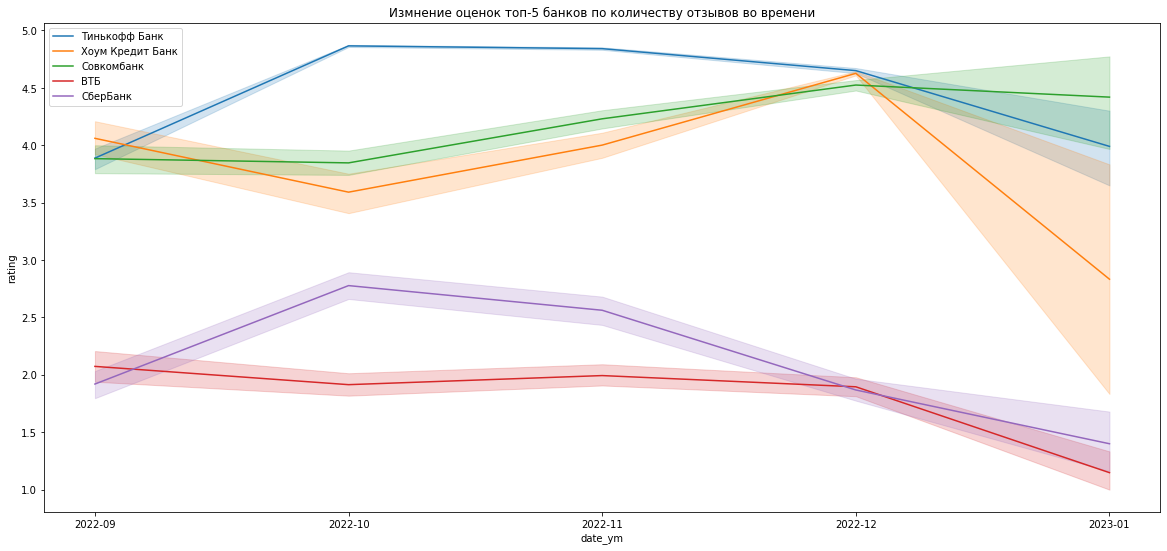

In [51]:
plt.figure(figsize=(20,9))
plt.title("Измнение оценок топ-5 банков по количеству отзывов во времени")

for bank in top15_count_body:
  sns.lineplot(x = "date_ym", y = "rating", data=data.loc[data['bank_name'] == bank][::-1], label=bank)

Выводы: 


*   До наступления 2023 разброс оценки был небольшой
*   После 2023 сильно упали рейтинги и вырости расбросы оценок у всех банков
*   Наиболее сильный негативный скачек наблюдается у банка хоум кредит
*   У Совкомбанка наоборот стуация лучшая из пятерки банков, что позволило обойти Тинькофф Банк
*   Возможно Хоум Кредит провели новую компанию, из-за которой мнения клиентов сильно разделились
 



---
### нет ли в данных в целом каких-то странностей на ваш взгляд?



1.   Меня смутило почему журнал велся в обратном порядке. Обычно данные добавляются последнем полем, но здесь ситуация обратная
2.   Новый пункт



---

# Моделирование

создание бинарного таргета

In [29]:
data['target'] = np.where(data.rating >= 3, 1, 0)

разделение выборки

In [30]:
train, val, test = np.split(data, [int(.7*len(data)), int(.85*len(data))])

In [64]:
print("Размер train выборки:\t", train.shape[0])
print("Размер valid выборки:\t", val.shape[0])
print("Размер test выборки:\t", test.shape[0])

Размер train выборки:	 64914
Размер valid выборки:	 13910
Размер test выборки:	 13911


In [32]:
X_train = train['body'].values
y_train = train['target'].values

X_val = val['body'].values
y_val = val['target'].values

X_test = test['body'].values
y_test = test['target'].values

создание вспомогательных функций-предобработки

In [33]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
    
def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
  
    return norm_docs

препроцессинг

In [34]:
X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

100%|██████████| 13911/13911 [00:03<00:00, 4444.62it/s]


In [35]:
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [36]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [37]:
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test = sequence.pad_sequences(X_test, maxlen=200)
X_val = sequence.pad_sequences(X_val, maxlen=200)

In [38]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [39]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 200
VOCAB_SIZE = len(t.word_index)

создание модели

In [40]:
model = Sequential()

# The Embedding Layer
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# The LSTM layer (64)
model.add(LSTM(64))

# The first DEnse layer (24,relu)
model.add(Dense(24, activation='relu'))

# The first DEnse layer (24,relu)
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='BinaryCrossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          4185900   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 4,280,925
Trainable params: 4,280,925
Non-trainable params: 0
_________________________________________________________________


обучение

In [41]:
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=10, validation_steps=30, verbose=1)

Epoch 1/10
2029/2029 [==============================] - 462s 226ms/step - loss: 0.3784 - accuracy: 0.8480 - val_loss: 0.2594 - val_accuracy: 0.9081
Epoch 2/10
2029/2029 [==============================] - 457s 225ms/step - loss: 0.3339 - accuracy: 0.8700 - val_loss: 0.2573 - val_accuracy: 0.9129
Epoch 3/10
2029/2029 [==============================] - 458s 226ms/step - loss: 0.3202 - accuracy: 0.8774 - val_loss: 0.2448 - val_accuracy: 0.9127
Epoch 4/10
2029/2029 [==============================] - 457s 225ms/step - loss: 0.3102 - accuracy: 0.8828 - val_loss: 0.2561 - val_accuracy: 0.9111
Epoch 5/10
2029/2029 [==============================] - 523s 258ms/step - loss: 0.3016 - accuracy: 0.8883 - val_loss: 0.2561 - val_accuracy: 0.9114
Epoch 6/10
2029/2029 [==============================] - 480s 237ms/step - loss: 0.2939 - accuracy: 0.8923 - val_loss: 0.2651 - val_accuracy: 0.9083
Epoch 7/10
2029/2029 [==============================] - 479s 236ms/step - loss: 0.2874 - accuracy: 0.8964 - val_

функции визуализации обучения модели

In [44]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

        
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

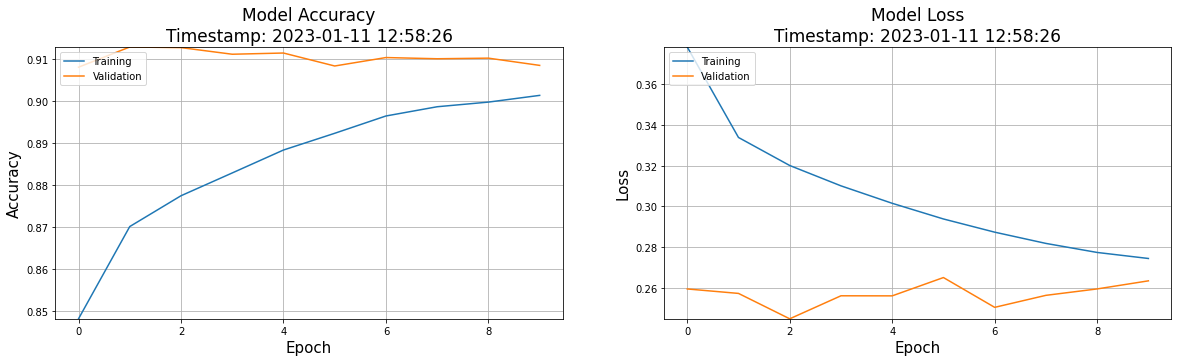

In [47]:
plot_performance(history=history1)

In [48]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

435/435 [==============================] - 26s 60ms/step - loss: 0.6379 - accuracy: 0.7048
Accuracy: 70.48%


In [49]:
model.save('Ai_trainsformation_binary_classification_task.h5')